### Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

**Цель:** В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.
Снова предсказание цены квартиры, но на сей раз съемной :)

* 1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

* 2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

&emsp; Переменные, которые пока нужно убрать: **id, name, host_id, host_name, last_review**. 

&emsp; Обратите внимание на распределение целевой переменной.

&emsp;Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

&emsp;Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "**center_distance**" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

* 3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :)
Критерии оценки: Максимум - 10 баллов

# Студент: Шокан

In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [404]:
df = pd.read_csv("datasets/AB_NYC_2019.csv").drop(["id", "name", "host_id", "host_name", "last_review"], axis=1)

### 1. Brief glance

In [405]:
df.shape

(48895, 11)

In [406]:
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


In [407]:
df.tail(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2
48894,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,1,23


In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [409]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [410]:
df.describe(exclude="number")

,neighbourhood_group,neighbourhood,room_type
count,48895,48895,48895
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21661,3920,25409


### 2. Обзор целевой переменной

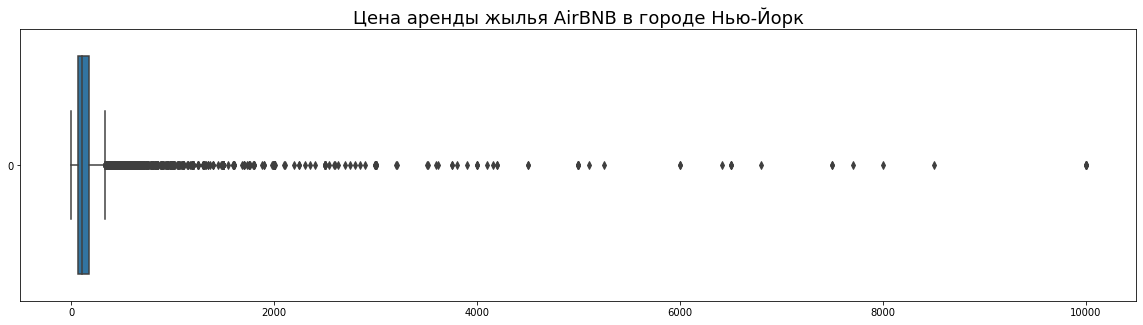

In [411]:
plt.figure(figsize=(20,5))
plt.title("Цена аренды жылья AirBNB в городе Нью-Йорк", fontsize=18)
sns.boxplot(data=df.price, orient="h")
plt.show()

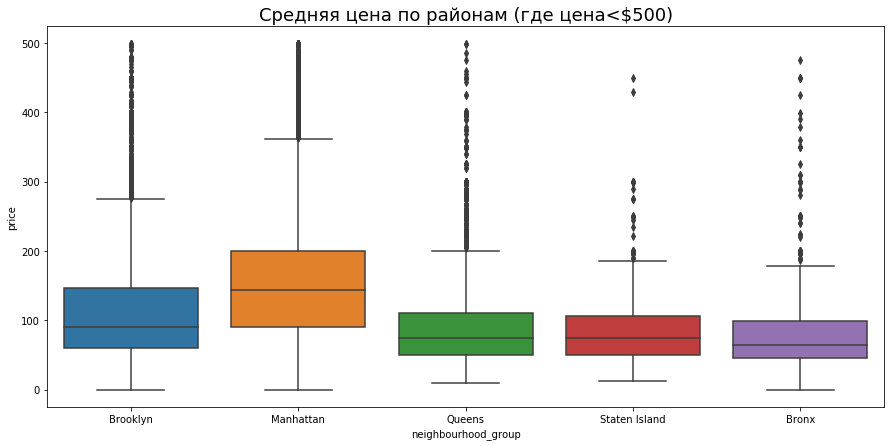

In [412]:
plt.figure(figsize=(15,7))
plt.title("Средняя цена по районам (где цена<$500)", fontsize=18)
sns.boxplot(data=df[df.price<500], y="price",x ='neighbourhood_group')
plt.show()

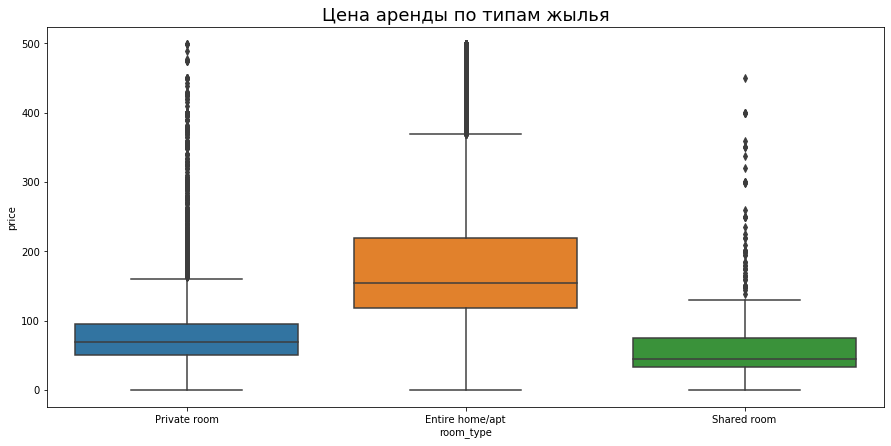

In [413]:
plt.figure(figsize=(15,7))
plt.title("Цена аренды по типам жылья", fontsize=18)
sns.boxplot(data=df[df.price<500], y="price",x ='room_type')
plt.show()

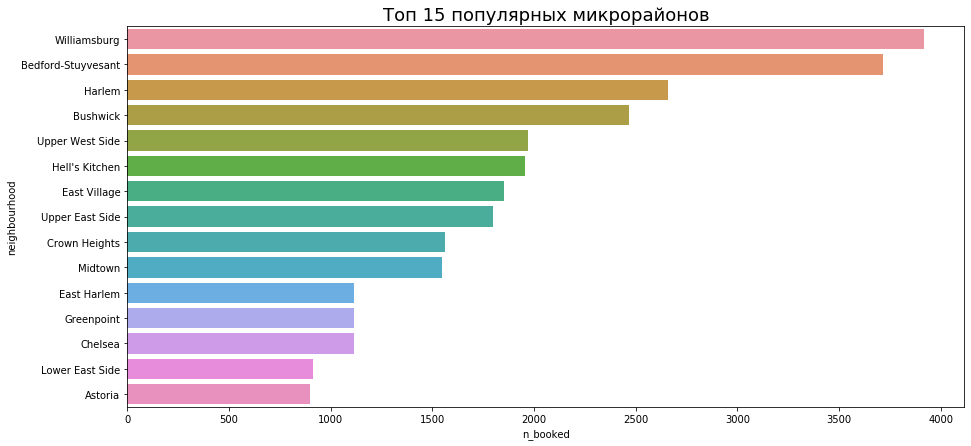

In [414]:
top_neigbourhoods = df.groupby("neighbourhood").size().\
sort_values(ascending=False).head(15).to_frame("n_booked").reset_index()

plt.figure(figsize=(15,7))
plt.title("Топ 15 популярных микрорайонов", fontsize=18)
sns.barplot(x=top_neigbourhoods.n_booked, y=top_neigbourhoods.neighbourhood, data=top_neigbourhoods, orient="h")
plt.show()

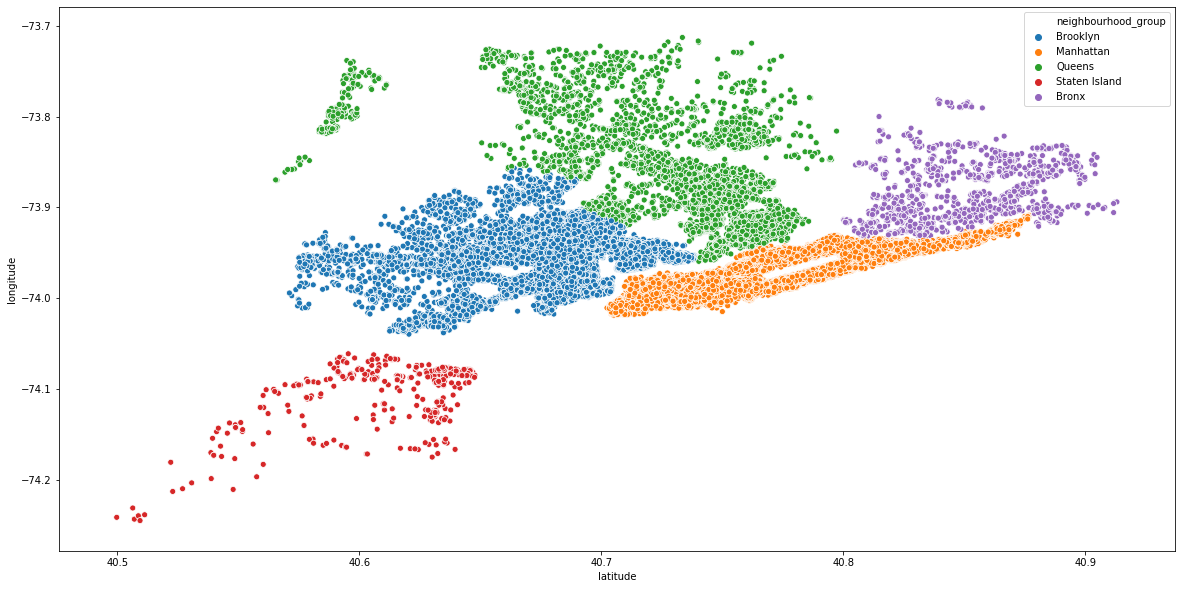

In [415]:
plt.figure(figsize=(20,10))
sns.scatterplot(df.latitude, df.longitude,hue=df.neighbourhood_group)
plt.ioff()

In [416]:
# Создаем новый атрибует, который будет отображать дистанцию от центра центра нью-йорка

from scipy.spatial import distance

def dst(x,y):
    point1 = (df.latitude.mean(), df.longitude.mean())
    point2 = (x, y)
    return  distance.euclidean(point1, point2)

center_distance = []
for i, r in df.iterrows():
    x=r["longitude"]
    y=r["latitude"]
    center_distance.append(dst(x,y))

df["center_distance"]=center_distance

In [417]:
df.drop(["longitude", "latitude"], axis=1, inplace=True)

In [418]:
df.corr()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
price,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829,0.128286
minimum_nights,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303,0.062166
number_of_reviews,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028,-0.052145
reviews_per_month,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791,-0.106931
calculated_host_listings_count,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701,0.092970
availability_365,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000,-0.064561
center_distance,0.128286,0.062166,-0.052145,-0.106931,0.092970,-0.064561,1.000000


### 3. Обработка данных

In [266]:
# Заполняем пустые данные
df["reviews_per_month"].fillna(0, inplace=True)

In [267]:
# Создаем класс, который выполняет мультикодирование выполненных столбцов
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns 

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col.astype(str))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Сбор колонок с типом object
cols = df.dtypes
objectCols = list(cols[cols=="object"].index.values)

df = MultiColumnLabelEncoder(columns=colList).fit_transform(df)
df.head()

In [270]:
# Проводим нормализацию 
data = df
data_n_2 = (data - data.mean()) / (data.std())

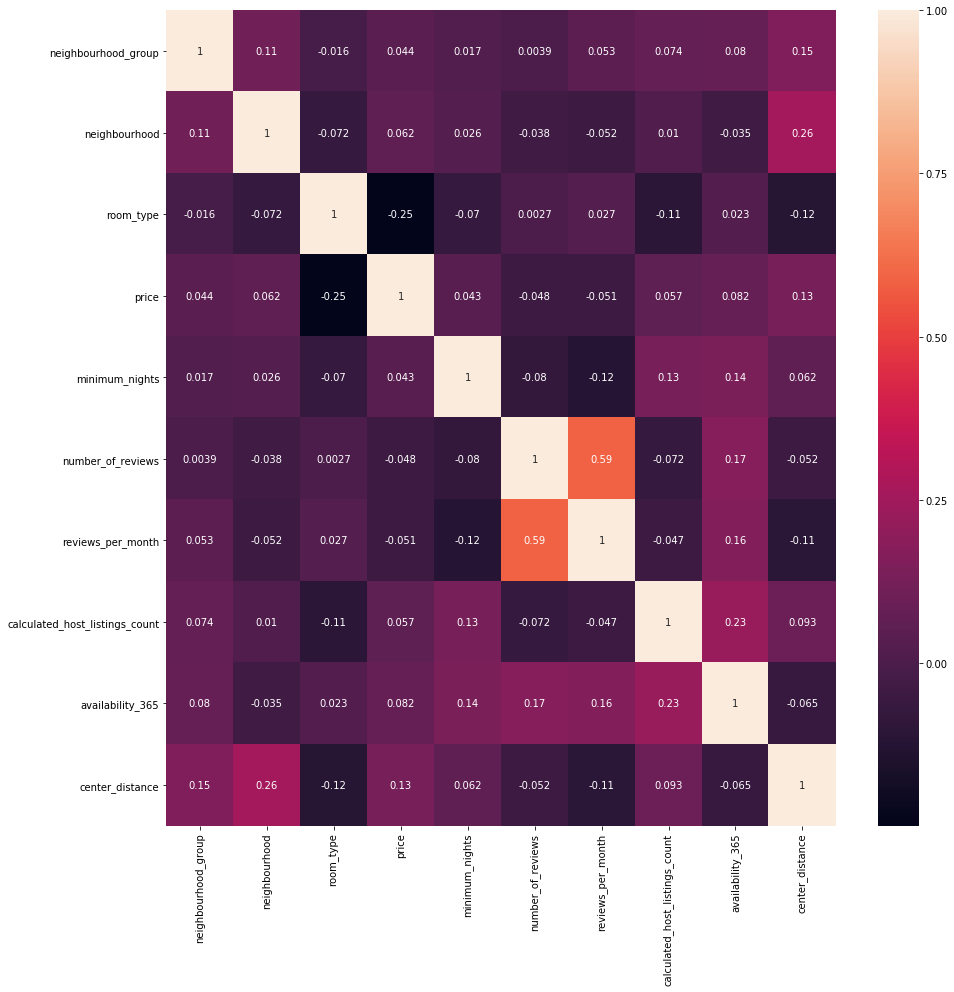

In [272]:
plt.figure(figsize=(15,15))
sns.heatmap(data_n_2.dropna().corr(), annot=True)

In [274]:
# Находим пары признаков с коэффициентом корреляции больше 0.1
corr = data_n_2.corr()
THRESHOLD = 0.1
CorField = []
for i in corr:
    for j in corr.index[corr[i] > THRESHOLD]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print("[{}] -> [{}]: {}".format(i, j, '%.4f' % corr[i][corr.index == j].values[0]))

[neighbourhood_group] -> [neighbourhood]: 0.1113
[neighbourhood_group] -> [center_distance]: 0.1547
[minimum_nights] -> [calculated_host_listings_count]: 0.1280
[minimum_nights] -> [availability_365]: 0.1443
[number_of_reviews] -> [reviews_per_month]: 0.5894


### 4. Моделирование (base line model)

In [389]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

In [390]:
X = data_n_2.drop("price", axis=1)
y = data.price

In [391]:
m_linear = LinearRegression()
m_ridge = RidgeCV()
m_lasso = LassoCV()
m_elasticnet = ElasticNetCV()

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34226, 9) (14669, 9) (34226,) (14669,)


In [393]:
m_linear.fit(X_train, y_train)
m_ridge.fit(X_train, y_train)
m_lasso.fit(X_train, y_train)
m_elasticnet.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [394]:
m_ridge.score

<bound method RegressorMixin.score of RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)>

In [395]:
def model_scores(modelName):
    y_pred = modelName.predict(X_test)
    mse = "\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test))
    rmse = "\nMSE: {:.4f}".format(math.sqrt(mean_squared_error(y_pred, y_test)))
    return mse, rmse

In [401]:
model_scores(m_linear)
model_scores(m_ridge)
model_scores(m_lasso)
model_scores(m_elasticnet)


MSE: 54782.5471 
MSE: 234.0567

MSE: 54782.5535 
MSE: 234.0567

MSE: 54784.5468 
MSE: 234.0610

MSE: 54800.2412 
MSE: 234.0945


### 5. Настройка модели (Tuning)